In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import scipy
from sklearn import preprocessing

In [58]:
attacks = pd.read_csv("/home/knel/virtual_envs/ankh-morpork/ICS_data_generation/data/swat_processed.csv", sep=",")

In [59]:
attacks = preprocessing.normalize(attacks.to_numpy(), norm="max", axis=0)

# swap sport to front
attacks[:, [0, 1]] = attacks[:, [1, 0]]
# swap dport to after sport
attacks[:, [1, 2]] = attacks[:, [2, 1]]
# swap protocols to after dport
attacks[:, [2, 14]] = attacks[:, [14, 2]]

# column order now -> sport, dport, protocols, continuous (discrete, discrete, discrete, continuous)

# should probably add batch and shuffle

train_dataset = attacks[:int(np.floor(attacks.shape[0]*3/4))]
test_dataset = attacks[int(np.floor(attacks.shape[0]*3/4)):]

num_features = attacks[:int(np.floor(attacks.shape[0]*3/4))].shape[1]
seq_length = 5
latent_dim = 500

In [60]:
class Sampling(tf.keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return tf.keras.backend.random_normal(tf.shape(log_var)) * tf.keras.backend.exp(log_var / 2) + mean

In [61]:
# encoder

inputs = tf.keras.layers.Input(shape=[num_features,1])
z = tf.keras.layers.Flatten()(inputs)
z = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(z)
z = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(z)
codings_mean = tf.keras.layers.Dense(latent_dim)(z) # mu
codings_log_var = tf.keras.layers.Dense(latent_dim)(z) # gamma
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = tf.keras.Model(inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

# decoder

decoder_inputs = tf.keras.layers.Input(shape=[latent_dim])
x = tf.keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal")(decoder_inputs)
x = tf.keras.layers.Dense(150, activation="relu", kernel_initializer="he_normal")(x)
x = tf.keras.layers.Dense(num_features*1, activation="sigmoid")(x)
outputs = tf.keras.layers.Reshape([num_features, 1])(x)
variational_decoder = tf.keras.Model(inputs=[decoder_inputs], outputs=[outputs])

# VAE model

_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = tf.keras.Model(inputs=[inputs], outputs=[reconstructions])

# VAE losses

latent_loss = -0.5 * tf.keras.backend.sum(1 + codings_log_var - tf.keras.backend.exp(codings_log_var) - tf.keras.backend.square(codings_mean), axis=-1)
variational_ae.add_loss(tf.keras.backend.mean(latent_loss / float(num_features)))
# variational_ae.add_loss(tf.keras.backend.mean(latent_loss))
optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-5)
variational_ae.compile(loss="binary_crossentropy", optimizer=optimizer)

In [62]:
def wasserstein_loss(y_pred, y_real):
    return tf.keras.backend.mean(y_pred * y_real)

def generator_wasserstein_loss(y_pred):
    return -tf.keras.backend.mean(y_pred)

class ClipConstraint(tf.keras.constraints.Constraint):
    def __init__(self, clip_value):
        self.clip_value = clip_value

In [83]:
def make_critic(input_shape):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    const = ClipConstraint(0.01)
    model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.Flatten(input_shape=(input_shape[0]*input_shape[1])))
    # model.add(tf.keras.layers.LSTM(100, input_shape=input_shape, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, return_sequences=True, name="c_lstm1"))
    # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, return_sequences=True, name="c_lstm2"))
    model.add(tf.keras.layers.Dense(200, input_shape=input_shape, kernel_initializer=init, kernel_constraint=const))
    model.add(tf.keras.layers.Dense(150, kernel_initializer=init, kernel_constraint=const))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, kernel_constraint=const, recurrent_dropout=0.4, name="c_lstm3"))
    model.add(tf.keras.layers.Dense(100, kernel_initializer=init, kernel_constraint=const))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    model.add(tf.keras.layers.Dense(1, name="c_dense"))
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

def make_generator(output_shape, noise_dim):
    init = tf.keras.initializers.RandomNormal(stddev=0.02)
    model = tf.keras.models.Sequential()
    # model.add(tf.keras.layers.LSTM(100, input_shape=(5, output_shape), kernel_initializer=init, recurrent_dropout=0.4, return_sequences=True))
    model.add(tf.keras.layers.Dense(50, input_shape=[noise_dim]))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    # model.add(tf.keras.layers.LSTM(100, kernel_initializer=init, recurrent_dropout=0.4))
    model.add(tf.keras.layers.Dense(80))
    model.add(tf.keras.layers.LeakyReLU(0.2))
    # model.add(tf.keras.layers.Dense(output_shape[0]*output_shape[1], activation="tanh", kernel_initializer=init))
    # model.add(tf.keras.layers.Reshape([output_shape[0], output_shape[1]]))
    model.add(tf.keras.layers.Dense(output_shape, activation="tanh"))
    # opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    # model.compile(loss=generator_wasserstein_loss, optimizer=opt)
    return model

def make_gan(generator, critic):
    model = tf.keras.models.Sequential()
    model.add(generator)
    model.add(critic)
    opt = tf.keras.optimizers.RMSprop(learning_rate=0.00005)
    model.compile(loss=wasserstein_loss, optimizer=opt)
    return model

## Step 1: Train autoencoder on real data

In [64]:
variational_ae.fit(train_dataset, train_dataset, epochs=3, batch_size=64)

Epoch 1/3
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.ops.tensor_array_ops.TensorArray'>):
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/keras/src/backend.py", line 5160, in <genexpr>
    output_ta_t = tuple(  File "/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/tensorflow/python/util/tf_should_use.py", line 288, in wrapped
    return _add_should_use_warning(fn(*args, **kwargs),
31151/31151 [==============================] - 45s 1ms/step - loss: 0.2492
Epoch 2/3
31151/31151 [==============================] - 44s 1ms/step - loss: 0.2222
Epoch 3/3
31151/31151 [==============================] - 45s 1ms/step - loss: 0.2179


## Step 2: Train GAN to learn realistic latent vectors

In [65]:
ix = np.random.randint(0, test_dataset.shape[0], 64)
real_latent_vectors = variational_encoder(test_dataset[ix])
test_dataset.shape[0]

664542

In [80]:

# train the generator and critic
def train(generator, critic, gan, dataset, latent_dim, noise_dim, n_epochs=2, n_batch=64, n_critic=5):
	# calculate the number of batches per training epoch
	bat_per_epo = int(dataset.shape[0] / n_batch)
	# calculate the number of training iterations
	n_steps = bat_per_epo * n_epochs
	# calculate the size of half a batch of samples
	half_batch = int(n_batch / 2)
	# lists for keeping track of loss
	c1_hist, c2_hist, g_hist = list(), list(), list()
	# manually enumerate epochs
	for i in range(n_steps):
		# update the critic more than the generator
		c1_tmp, c2_tmp = list(), list()
		for _ in range(n_critic):
			# get randomly selected 'real' samples
			ix = np.random.randint(0, dataset.shape[0], n_batch)
			real_latent_vectors = variational_encoder(dataset[ix])[0]
			y_real = np.ones((n_batch, 1))
			# update critic model weights
			c_loss1 = critic.train_on_batch(real_latent_vectors, y_real)
			c1_tmp.append(c_loss1)
			# generate 'fake' examples
			# noise = np.random.randn(latent_dim * n_batch)
			# noise = noise.reshape(32, n_batch, latent_dim)
			# noise = tf.random.normal((n_batch, 5, noise_dim))
			noise = tf.random.normal((n_batch, noise_dim))
			# fake_latent_vectors = generator.predict(noise)
			fake_latent_vectors = generator(noise)
			y_fake = -np.ones((n_batch, 1))
			# update critic model weights
			c_loss2 = critic.train_on_batch(fake_latent_vectors, y_fake)
			c2_tmp.append(c_loss2)
		# store critic loss
		c1_hist.append(np.mean(c1_tmp))
		c2_hist.append(np.mean(c2_tmp))
		# prepare points in latent space as input for the generator
		# noise = np.random.randn(latent_dim * n_batch)
		# noise = noise.reshape(n_batch, latent_dim)
		# noise = tf.random.normal((n_batch, 5, noise_dim))
		noise = tf.random.normal((n_batch, noise_dim))
		# create inverted labels for the fake samples
		y_gan = -np.ones((n_batch, 1))
		# update the generator via the critic's error
		g_loss = gan.train_on_batch(noise, y_gan)
		g_hist.append(g_loss)
		# summarize loss on this batch
		print('>%d, c1=%.4f, c2=%.4f g=%.4f' % (i+1, c1_hist[-1], c2_hist[-1], g_loss))
	return c1_hist, c2_hist, g_hist

In [72]:
real_latent_vectors = variational_encoder(test_dataset)[0]
real_latent_vectors.shape

TensorShape([664542, 500])

In [84]:

noise_dim = 30
n_batch = 64
# create the critic
critic = make_critic([latent_dim, 1])
# create the generator
# generator = make_generator((n_batch, latent_dim))
generator = make_generator(latent_dim, noise_dim)
# create the gan
gan = make_gan(generator, critic)
# load image data


real_latent_vectors = variational_encoder(test_dataset)[0]
epochs = 10
# train model
c1_loss, c2_loss, g_loss = train(generator, critic, gan, dataset=test_dataset[:10000], latent_dim=latent_dim, noise_dim=noise_dim, n_epochs=epochs, n_batch=n_batch)

>1, c1=-0.0003, c2=0.0009 g=0.0002
>2, c1=0.0007, c2=-0.0004 g=-0.0007
>3, c1=0.0011, c2=-0.0010 g=-0.0013
>4, c1=0.0015, c2=-0.0015 g=-0.0018
>5, c1=0.0018, c2=-0.0019 g=-0.0022
>6, c1=0.0022, c2=-0.0023 g=-0.0026
>7, c1=0.0025, c2=-0.0026 g=-0.0030
>8, c1=0.0027, c2=-0.0030 g=-0.0033
>9, c1=0.0030, c2=-0.0033 g=-0.0036
>10, c1=0.0033, c2=-0.0036 g=-0.0040
>11, c1=0.0036, c2=-0.0040 g=-0.0043
>12, c1=0.0038, c2=-0.0043 g=-0.0046
>13, c1=0.0041, c2=-0.0046 g=-0.0050
>14, c1=0.0044, c2=-0.0049 g=-0.0052
>15, c1=0.0046, c2=-0.0052 g=-0.0056
>16, c1=0.0049, c2=-0.0055 g=-0.0059
>17, c1=0.0052, c2=-0.0058 g=-0.0062
>18, c1=0.0054, c2=-0.0061 g=-0.0065
>19, c1=0.0057, c2=-0.0065 g=-0.0068
>20, c1=0.0060, c2=-0.0068 g=-0.0071
>21, c1=0.0062, c2=-0.0071 g=-0.0075
>22, c1=0.0065, c2=-0.0074 g=-0.0078
>23, c1=0.0068, c2=-0.0077 g=-0.0082
>24, c1=0.0070, c2=-0.0081 g=-0.0084
>25, c1=0.0073, c2=-0.0085 g=-0.0089
>26, c1=0.0076, c2=-0.0088 g=-0.0092
>27, c1=0.0079, c2=-0.0091 g=-0.0097
>28, c1=0.0

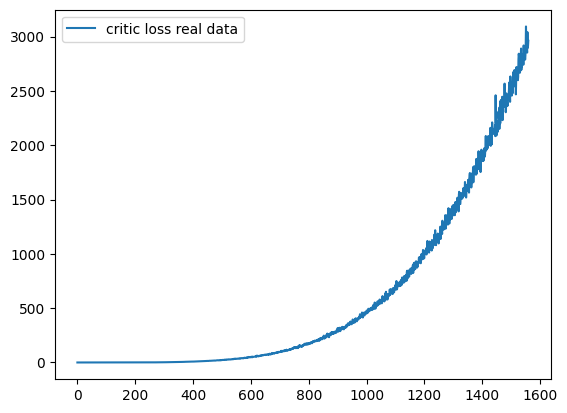

In [86]:
plt.plot(c1_loss, label="critic loss real data")
# plt.plot(c2_loss, label="critic loss fake data")
# plt.plot(g_loss, label="gen loss")
plt.legend()
plt.show()

## Step 3: Use generator to make latent vectors and decode with decoder

In [70]:
noise = tf.random.normal((n_batch, 5, latent_dim))
latent_vectors = generator.predict(noise)
data = variational_decoder(latent_vectors)
data[0]

ValueError: in user code:

    File "/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/keras/src/engine/training.py", line 2416, in predict_function  *
        return step_function(self, iterator)
    File "/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/keras/src/engine/training.py", line 2401, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/keras/src/engine/training.py", line 2389, in run_step  **
        outputs = model.predict_step(data)
    File "/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/keras/src/engine/training.py", line 2357, in predict_step
        return self(x, training=False)
    File "/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/home/knel/virtual_envs/ankh-morpork/lib/python3.11/site-packages/keras/src/engine/input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_45" is incompatible with the layer: expected shape=(None, 30), found shape=(32, 5, 500)
